# Rates & Angles

In [2]:
from config.settings import LocalDataPath, OutPath, PlotsPath
from config.plot_config import set_plot_style; set_plot_style()
from utils.functions import gaussian
import os
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pickle
import seaborn as sns
import math
from scipy.optimize import curve_fit

In [3]:
#plot params
label_fontsize = 20
plt.rcParams["xtick.labelsize"] = label_fontsize
plt.rcParams["ytick.labelsize"] = label_fontsize

In [4]:
with open(f"{OutPath}/run_TLV.pkl", "rb") as f:
    run_TLV = pickle.load(f)

with open(f"{OutPath}/run_SN.pkl", "rb") as f:
    run_SN = pickle.load(f)

with open(f"{OutPath}/run_WE.pkl", "rb") as f:
    run_WE = pickle.load(f)

In [40]:
# Gather Data
data_TLV = run_TLV.get_data()
data_SN  = run_SN.get_data()
data_WE  = run_WE.get_data()

# Timestamps
timestamps_TLV = np.array([tup[0] for tup in data_TLV])
timestamps_SN  = np.array([tup[0] for tup in data_SN])
timestamps_WE  = np.array([tup[0] for tup in data_WE])

# Angles, with angles2,3 and 4 being events for only 2,3 and 4 hist respectively
angles_TLV = np.array([tup[1] for tup in data_TLV])
angles_SN  = np.array([tup[1] for tup in data_SN])
angles_WE  = np.array([tup[1] for tup in data_WE])

angles2_TLV = np.array([tup[1] for tup in data_TLV if tup[2] == 2])
angles2_SN  = np.array([tup[1] for tup in data_SN if tup[2] == 2])
angles2_WE  = np.array([tup[1] for tup in data_WE if tup[2] == 2])

angles3_TLV = np.array([tup[1] for tup in data_TLV if tup[2] == 3])
angles3_SN  = np.array([tup[1] for tup in data_SN if tup[2] == 3])
angles3_WE  = np.array([tup[1] for tup in data_WE if tup[2] == 3])

angles4_TLV = np.array([tup[1] for tup in data_TLV if tup[2] == 4])
angles4_SN  = np.array([tup[1] for tup in data_SN if tup[2] == 4])
angles4_WE  = np.array([tup[1] for tup in data_WE if tup[2] == 4])

angles1_TLV = np.array([tup[1] for tup in data_TLV if tup[2] == 1])
angles1_SN  = np.array([tup[1] for tup in data_SN if tup[2] == 1])
angles1_WE  = np.array([tup[1] for tup in data_WE if tup[2] == 1])

angles0_TLV = np.array([tup[1] for tup in data_TLV if tup[2] == 0])
angles0_SN  = np.array([tup[1] for tup in data_SN if tup[2] == 0])
angles0_WE  = np.array([tup[1] for tup in data_WE if tup[2] == 0])

angles_SN_in  = np.array([tup[1] for tup in data_SN if tup[2] > 1])
angles_WE_in  = np.array([tup[1] for tup in data_WE if tup[2] > 1])

## Rates

In [5]:
rate_TLV, drate_TLV = run_TLV.get_rate()
rate_SN, drate_SN   = run_SN.get_rate()
rate_WE, drate_WE   = run_WE.get_rate()

data = [
    ["TLV", rate_TLV, drate_TLV],
    ["KYUL-SN", rate_SN,drate_SN],
    ["KYUL-WE", rate_WE, drate_WE]
]

headers = ["Location", "Rate", "Stat Err"]

table = PrettyTable()
table.field_names = headers
for row in data:
    table.add_row(row)

print(table)

# ---

N = len(timestamps_SN) + len(timestamps_WE)
b = len(timestamps_SN) / N
c = len(timestamps_WE) / N

sup = np.round(rate_TLV / (b*rate_SN + c*rate_WE) , 2)
ERR = np.round(76.61410894258873, 2) # from http://www.julianibus.de/
# ---

muon_flux0    = 1.67e-2 #cm^{-2} sec6{-1} 
muon_flux_sup = np.round(muon_flux0 / sup, 8)
ERR_flux = 6.44e-8 # from http://www.julianibus.de/

print("Total Supression Factor = ", f"{sup} +- {ERR}")
print("Absolute flux underground = ", f"{muon_flux_sup} +- {ERR_flux}")

+----------+----------+----------+
| Location |   Rate   | Stat Err |
+----------+----------+----------+
|   TLV    | 38.02813 | 0.36258  |
| KYUL-SN  | 0.00854  | 0.00021  |
| KYUL-WE  | 0.00853  | 0.00015  |
+----------+----------+----------+
Total Supression Factor =  4456.35 +- 76.61
Absolute flux underground =  3.75e-06 +- 6.44e-08


In [6]:
# Boundaries
SN1 = 631

WE1 = 725
WE2 = WE1 + 743
WE3 = WE2 + 690

sn1 = ((timestamps_SN[:SN1] / 3600) + 16.63) 
sn2 = ((timestamps_SN[SN1:] / 3600) + 15.1 )

we1 = ((timestamps_WE[:WE1] / 3600) + 7.7)
we2 = ((timestamps_WE[WE1:WE2] / 3600) + 7.3)
we3 = ((timestamps_WE[WE2:WE3] / 3600) + 6.9)
we4 = ((timestamps_WE[WE3:] / 3600) + 7.3)

hrs  = 1
bins = np.arange(0, 25, hrs)
bin_mids = bins[:-1] + np.diff(bins/2)

# split to two 24 hr blocks
def split24(arr):
    a = np.array([t for t in arr if 0 <= t < 24])
    b = np.array(([t for t in arr if 24 <= t < 48])) % 24
    return a, b

def resolve_hist(arr, sort, bins=bins):

    # sort is 'a' or 'b'
    
    # get the real time interval of first and last bins
    init_time = arr[0]
    bin_end   = math.ceil(init_time)
    real_time_first = bin_end - init_time

    end_time    = arr[-1]
    bin_start   = math.floor(end_time)
    real_time_last = end_time - bin_start

    if sort == 'a':
        hist, bin_edges = np.histogram(arr, bins = bins)
        errs = np.sqrt(hist)

        first_nonzero_idx = np.argwhere(hist)[0]
        
        hist[first_nonzero_idx] = hist[first_nonzero_idx]/real_time_first
        errs[first_nonzero_idx] = errs[first_nonzero_idx]/real_time_first

    elif sort == 'b':
        hist, bin_edges = np.histogram(arr, bins = bins)
        errs = np.sqrt(hist)

        last_nonzero_idx = np.argwhere(hist)[-1]
        
        hist[last_nonzero_idx] = hist[last_nonzero_idx]/real_time_last
        errs[last_nonzero_idx] = errs[last_nonzero_idx]/real_time_last
    
    return hist, errs
    

sn1_a, sn1_b = split24(sn1)
sn2_a, sn2_b = split24(sn2)

we1_a, we1_b = split24(we1)
we2_a, we2_b = split24(we2)
we3_a, we3_b = split24(we3)
we4_a, we4_b = split24(we4)

a_array = [sn1_a, sn2_a, we1_a, we2_a, we3_a, we4_a]
b_array = [sn1_b, sn2_b, we1_b, we2_b, we3_b, we4_b]

A = []
a_resolved = []
for arr in a_array:
    sort = 'a'

    hist, errs = resolve_hist(arr, sort=sort)
    a_resolved.append([hist, errs])


B = []
b_resolved = []
for arr in b_array:
    sort = 'b'

    hist, errs = resolve_hist(arr, sort=sort)
    b_resolved.append([hist, errs])

# So now we have all the error resolved array

# Create a matrix
mtx = np.concatenate((a_resolved, b_resolved))

# count division instances (by how many to divide by when averaging
count_arr = np.full(24, 0)

for row in mtx:
    for idx, elm in enumerate(row[0]):
        if elm != 0:
            count_arr[idx] += 1

# now sum the matrix
summed_arr = np.array(np.sum([row[0] for row in mtx], axis=0))

# combine the erros
combined_errs =np.array(np.sqrt(np.sum([(row[1]**2) for row in mtx], axis=0)))

# and divide by count_arr
averaged_arr = summed_arr / count_arr

averaged_errs = combined_errs / count_arr

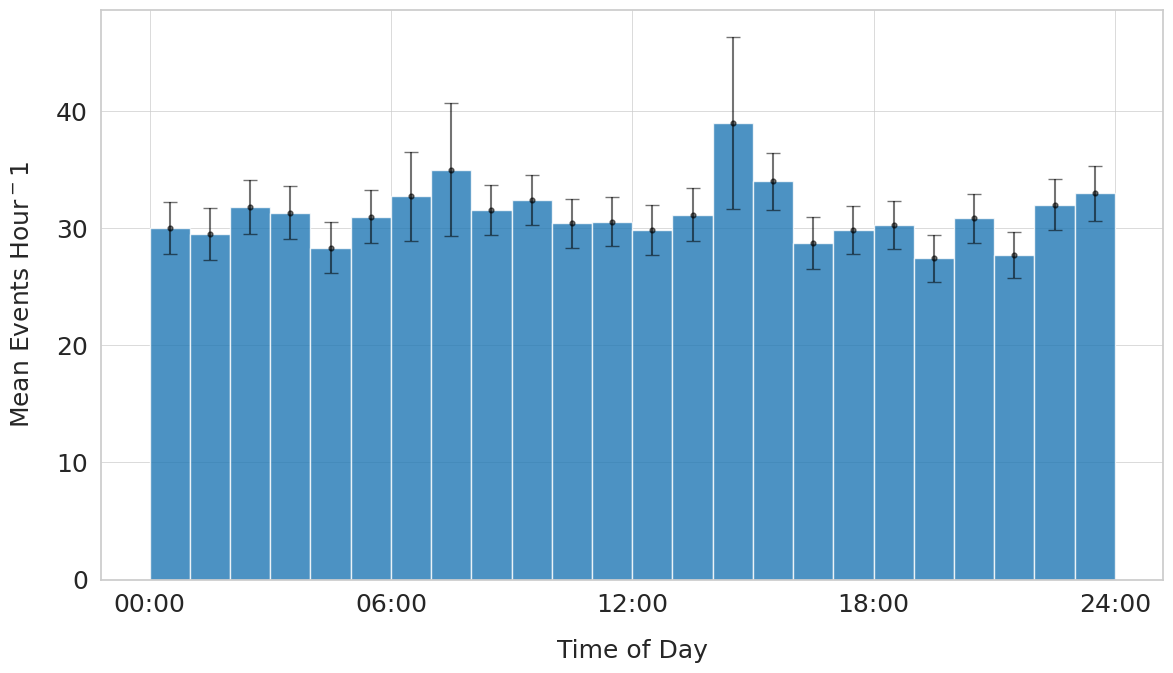

In [7]:
fig, ax = plt.subplots(figsize = (12,7))

# Define a professional blue color
blue_colour = "#1f77b4"

ax.bar(bin_mids, averaged_arr, width = hrs, color = blue_colour, linewidth = 1, alpha = 0.8)
ax.errorbar(bin_mids, averaged_arr, yerr = averaged_errs, 
             markersize=3.5, 
             fmt='o', 
             color='black', 
             capsize = 5, 
             zorder=3,
             alpha = 0.55
           )

ax.set_ylabel(rf"Mean Events Hour$^{-1}$", labelpad=16, fontsize = label_fontsize)
ax.set_xlabel("Time of Day", labelpad=16, fontsize = label_fontsize)

ax.set_xticks([0, 6, 12, 18, 24], labels = ["00:00","06:00","12:00","18:00","24:00"], fontsize = label_fontsize);
ax.set_yticks([0, 10, 20, 30, 40], labels = [0, 10, 20, 30, 40], fontsize = label_fontsize)

fig.tight_layout()

savepath = os.path.join(PlotsPath, "hourly_rate.png")
plt.savefig(savepath, dpi = 400)

#ax.grid(False);

[ 0.20463318 30.85442531  1.84710951]


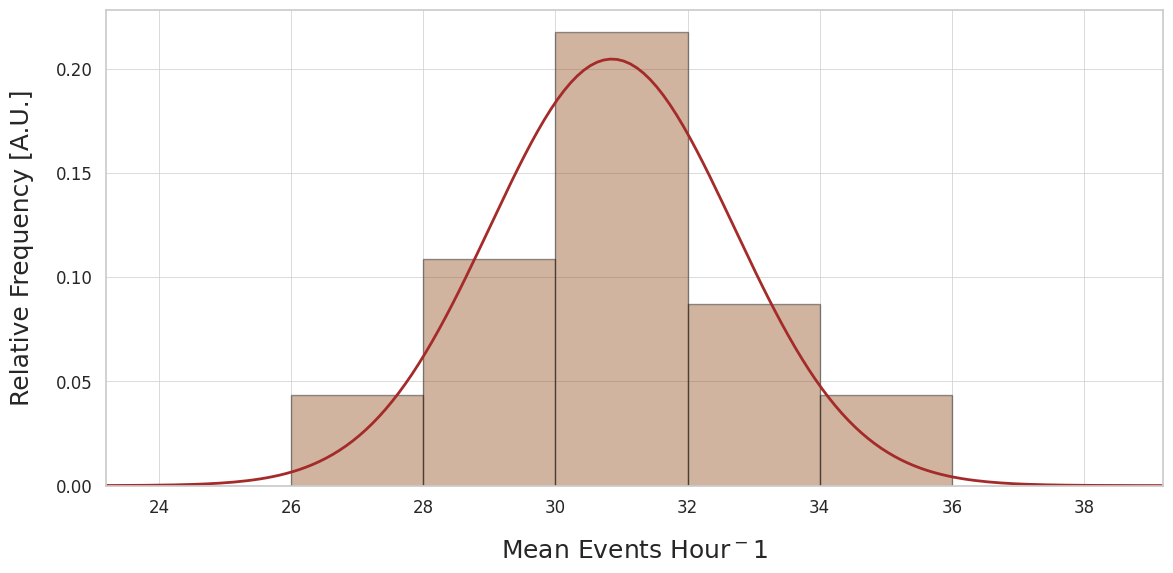

In [8]:
# Distribution of Hourly Rates

brown_colour = '#8B4513'

fig, ax = plt.subplots(figsize=(12,6))

w = 2
bins = np.arange(31-7,31+7,w)
hist, bin_edges = np.histogram(averaged_arr, bins=bins, density = True)
bin_mids = bin_edges[:-1] + np.diff(bin_edges)/2

popt, pcov = curve_fit(gaussian, bin_mids, hist, p0 = [20, 10, 31])

x_vals = np.linspace(0,100,1000)
ax.plot(x_vals, gaussian(x_vals, *popt), color = 'brown', lw = 2)

ax.bar(bin_mids, hist, width = w, color = brown_colour, edgecolor='black', lw = 1, alpha = 0.4)
ax.set_xlim(31.2 - 8, 31.2 + 8)

ax.set_ylabel("Relative Frequency [A.U.]", labelpad=16, fontsize = label_fontsize)
ax.set_xlabel(rf"Mean Events Hour$^{-1}$", labelpad=16, fontsize = label_fontsize)

fig.tight_layout()

savepath = os.path.join(PlotsPath, "hourly_rate_dist.png")
plt.savefig(savepath, dpi = 400)

print(popt)

## Angular Distribution

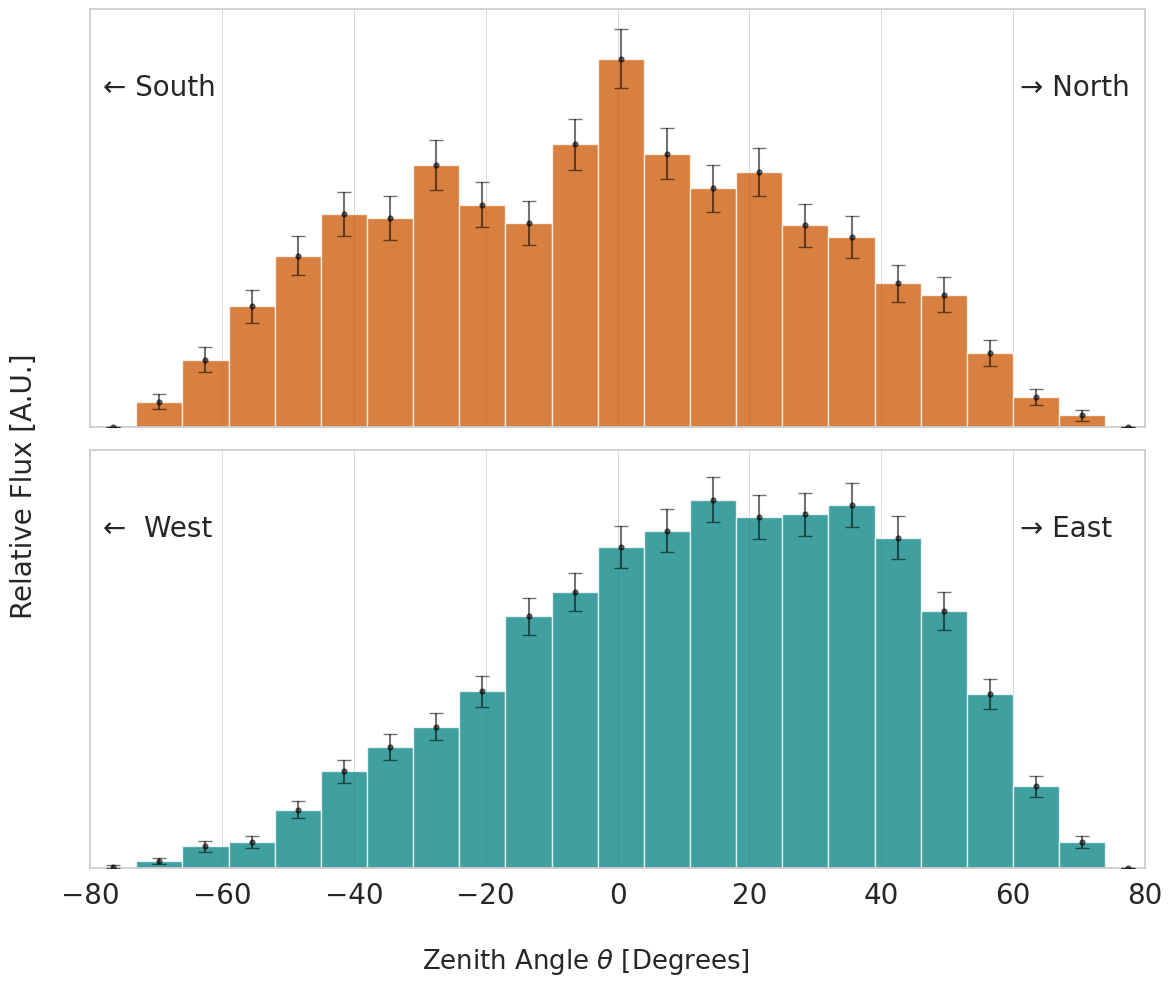

In [30]:
oran = '#CC5500'
gree = '#008080'

w = 7
bins = np.arange(-80, 90, w)
bin_mids = bins[:-1] + np.diff(bins)/2

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(12,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

alpha = 0.75

hist_SN, bin_edges = np.histogram(angles_SN, bins = bins)
errs_SN = np.sqrt(hist_SN)
norm = np.max(hist_SN)

hist_SN = hist_SN / norm
errs_SN = errs_SN / norm

hist_WE, bin_edges = np.histogram(angles_WE, bins = bins)
errs_WE = np.sqrt(hist_WE)
norm = np.max(hist_WE)

hist_WE = hist_WE / norm
errs_WE = errs_WE / norm


ax1.set_xlim(-80,80)

ax1.bar(bin_mids, hist_SN, width = w, color = oran, alpha = alpha)
ax1.errorbar(bin_mids, hist_SN, yerr = errs_SN, 
             markersize=3.5, 
             fmt='o', 
             color='black', 
             capsize = 5, 
             zorder=3,
             alpha = 0.55
           )

ax2.bar(bin_mids, hist_WE, width = w, color = gree, alpha = alpha)
ax2.errorbar(bin_mids, hist_WE, yerr = errs_WE, 
             markersize=3.5, 
             fmt='o', 
             color='black', 
             capsize = 5, 
             zorder=3,
             alpha = 0.55
           )


#ax1.hist(angles_SN, alpha = alpha, density = True, color = oran, bins = bins)
#ax2.hist(angles_WE, alpha = alpha, density = True, color = gree, bins = bins)

ax1.text(61, 0.9, "→ North", fontsize=20)
ax1.text(-78, 0.9, "← South", fontsize=20)

ax2.text(61, 0.9, "→ East", fontsize=20)
ax2.text(-78, 0.9, "←  West", fontsize=20)



#ax1.set_xlabel(r"Zenith Angle $\theta$", fontsize = label_fontsize)
fig.supylabel("Relative Flux [A.U.]", fontsize = label_fontsize)
fig.subplots_adjust(left=0.06)
fig.subplots_adjust(bottom=0.12) 
fig.supxlabel(r"Zenith Angle $\theta$ [Degrees]")

ax1.set_yticks([])

fig.tight_layout()

savepath = os.path.join(PlotsPath, "angular_dist.png")
plt.savefig(savepath, dpi = 400);

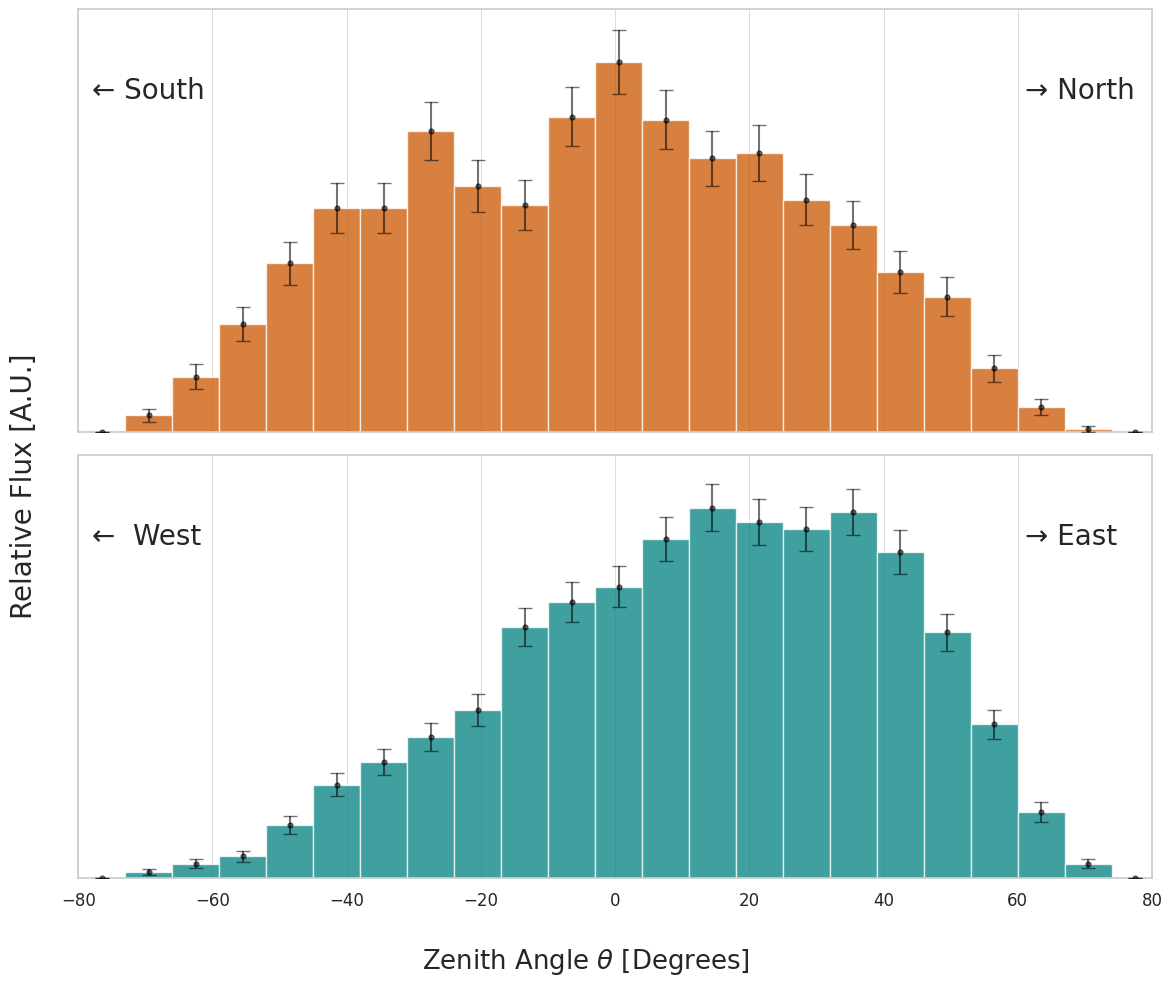

In [41]:
oran = '#CC5500'
gree = '#008080'

w = 7
bins = np.arange(-80, 90, w)
bin_mids = bins[:-1] + np.diff(bins)/2

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(12,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

alpha = 0.75

hist_SN, bin_edges = np.histogram(angles_SN_in, bins = bins)
errs_SN = np.sqrt(hist_SN)
norm = np.max(hist_SN)

hist_SN = hist_SN / norm
errs_SN = errs_SN / norm

hist_WE, bin_edges = np.histogram(angles_WE_in, bins = bins)
errs_WE = np.sqrt(hist_WE)
norm = np.max(hist_WE)

hist_WE = hist_WE / norm
errs_WE = errs_WE / norm


ax1.set_xlim(-80,80)

ax1.bar(bin_mids, hist_SN, width = w, color = oran, alpha = alpha)
ax1.errorbar(bin_mids, hist_SN, yerr = errs_SN, 
             markersize=3.5, 
             fmt='o', 
             color='black', 
             capsize = 5, 
             zorder=3,
             alpha = 0.55
           )

ax2.bar(bin_mids, hist_WE, width = w, color = gree, alpha = alpha)
ax2.errorbar(bin_mids, hist_WE, yerr = errs_WE, 
             markersize=3.5, 
             fmt='o', 
             color='black', 
             capsize = 5, 
             zorder=3,
             alpha = 0.55
           )


#ax1.hist(angles_SN, alpha = alpha, density = True, color = oran, bins = bins)
#ax2.hist(angles_WE, alpha = alpha, density = True, color = gree, bins = bins)

ax1.text(61, 0.9, "→ North", fontsize=20)
ax1.text(-78, 0.9, "← South", fontsize=20)

ax2.text(61, 0.9, "→ East", fontsize=20)
ax2.text(-78, 0.9, "←  West", fontsize=20)



#ax1.set_xlabel(r"Zenith Angle $\theta$", fontsize = label_fontsize)
fig.supylabel("Relative Flux [A.U.]", fontsize = label_fontsize)
fig.subplots_adjust(left=0.06)
fig.subplots_adjust(bottom=0.12) 
fig.supxlabel(r"Zenith Angle $\theta$ [Degrees]")

ax1.set_yticks([])

fig.tight_layout()

savepath = os.path.join(PlotsPath, "angular_dist_in.png")
plt.savefig(savepath, dpi = 400);

In [10]:
sn_mean = np.round(np.nanmean(angles_SN),1)
sn_spread = np.round(np.nanstd(angles_SN), 1)
we_mean = np.round(np.nanmean(angles_WE),1)
we_spread = np.round(np.nanstd(angles_WE), 1)
print("SN Mean Angle: ", sn_mean, "   Spread: ", sn_spread)
print("WE Mean Angle: ", we_mean, "   Spread: ", we_spread)

SN Mean Angle:  -2.7    Spread:  31.5
WE Mean Angle:  13.2    Spread:  28.6


## Hit Distributions

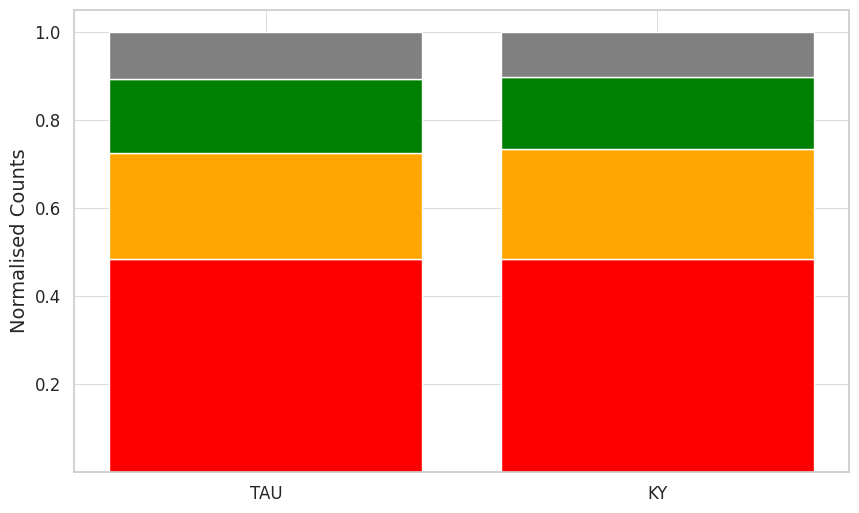

In [37]:
tau_tot = len(angles_TLV)
ky_tot  = len(angles_SN) + len(angles_WE)

tau_2 = len(angles2_TLV) / tau_tot
tau_3 = len(angles3_TLV) / tau_tot
tau_4 = len(angles4_TLV) / tau_tot
tau_out = (len(angles0_TLV) + len(angles1_TLV)) / tau_tot


ky_2 = (len(angles2_SN) + len(angles2_WE)) / ky_tot
ky_3 = (len(angles3_SN) + len(angles3_WE)) / ky_tot
ky_4 = (len(angles4_SN) + len(angles4_WE)) / ky_tot
ky_out = (len(angles0_SN) + len(angles1_SN) + len(angles0_WE) + len(angles1_WE)) / ky_tot

x  = ["TAU", "KY"]
y2 = np.array([tau_2, ky_2])
y3 = np.array([tau_3, ky_3])
y4 = np.array([tau_4, ky_4])
yout = np.array([tau_out, ky_out])

plt.bar(x, y2, color='red')
plt.bar(x, y3, bottom=y2, color='orange')
plt.bar(x, y4, bottom=y2+y3, color='green')
plt.bar(x, yout, bottom=y2+y3+y4, color='grey')

plt.ylabel("Normalised Counts")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1]);